## Préambule

In [5]:
#Chargement de dépendances

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta
#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

distmat=abs(np.subtract.outer(discretization,discretization))
Sigma=Covexp(distmat,a,sigma2)

SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]
SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

Cholesky = np.linalg.cholesky(SigmaCond)

allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth

def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

# Projet Numérique de Probabilités

## Valeurs Positives

### Question 1

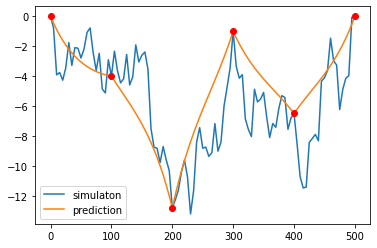

In [10]:
def simu_pos():
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu = Ec + np.matmul(Cholesky,x)
    
    while any(x > 0 for x in simu):
        x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        simu = Ec + np.matmul(Cholesky,x)

    return simu

simu = simu_pos()
        
allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth
plt.plot(discretization,allval3, label='simulaton')
plt.plot(discretization,allval1, label='prediction')
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.legend();

### Question 2

La valeur moyenne de la longueur du câble est 521.80m, ce qui est quasiment le même résultat que pour la simulation où on 
permet des altitudes positives.
L'intervalle de confiance à 95% est [516.72,527.63]. Là aussi, on retrouve des résultats très similaires à la simulation 
précédente.
Enfin, la probabilité que la longueur du câble dépasse 525m est 0.134, ce qui est plus faible que pour la simulation 
précédente.


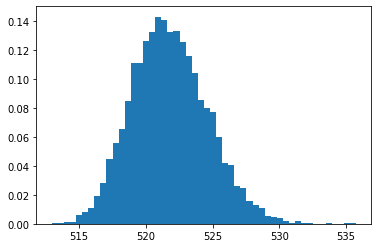

Le taux de rejet de l'algorithme choisi est 0.962. C'est très élevé, ce qui explique que ce bloc de code soit relativement long à faire tourner.


In [11]:
K = 10000
result = np.zeros(K)
for i in range(K):
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes] = simu_pos()
    result[i]=length(allval3,Delta)

quantiles = np.quantile(result,[0.025,0.975])
    
print(f"""La valeur moyenne de la longueur du câble est {sum(result)/K:.2f}m, ce qui est quasiment le même résultat que pour la simulation où on 
permet des altitudes positives.\nL'intervalle de confiance à 95% est [{quantiles[0]:.2f},{quantiles[1]:.2f}]. Là aussi, on retrouve des résultats très similaires à la simulation 
précédente.\nEnfin, la probabilité que la longueur du câble dépasse 525m est {np.mean(result>525):.3f}, ce qui est plus faible que pour la simulation 
précédente.""")

plt.hist(result,50,density=True)
plt.show();

rejet = 0
for i in range(K):
    x = x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    simu = Ec + np.matmul(Cholesky,x)
    if any(x > 0 for x in simu):
        rejet += 1
        
print(f"Le taux de rejet de l'algorithme choisi est {rejet / K:.3f}. C'est très élevé, ce qui explique que ce bloc de code soit relativement long à faire tourner.")

## Approche Bayésienne

### Question 3

En considérant la densité jointe du vecteur $(Z_{OBS}, \mu)$ on a:
     $$f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},x) = f_{\mathbf{Z}_{\text{OBS}}|\mu=x}(\mathbf{z}_{\text{OBS}})f_{\mu}(x)$$
   
Or $$\mu \sim \mathcal{N}(-5,4)$$ et $$\mathbf{Z}_{\text{OBS}} | \mu = x \sim \mathcal{N}(x,C_{\text{OBS}})$$ puisque µ représente la moyenne.

On a donc : $$\left\{\begin{matrix}
f_{\mu}(x) = \frac{1}{2\sqrt{2\pi}}\text{exp}(-\frac{1}{2}(\frac{x + 5}{2})^2)\\ 
f_{\mathbf{Z}_{\text{OBS}}|\mu=x}(\mathbf{z}_{\text{OBS}}) = \frac{1}{(2\pi)^3\sqrt{\text{det}(C_{\text{OBS}})}}\text{exp}(-\frac{1}{2}(z_{\text{OBS}} - \mathbf{1}x)^TC_{\text{OBS}}^{-1}(z_{\text{OBS}} - \mathbf{1}x))
\end{matrix}\right.$$

D'où, en passant à -2ln :

$$-2\ln(f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},x)) = (\mathbf{z}_{\text{OBS}}-\mathbf{1}{x})^{T}C_{\text{OBS}}^{-1}(\mathbf{z}_{\text{OBS}}-\mathbf{1}{x})+ (\frac{5+x}{2})^2+\ln(8\pi)+\ln((2\pi)^6det(C_{\text{OBS}}))$$
    
D'autre part, on a : $$f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},x) = f_{\mu|\mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}}(x)f_{\mathbf{Z}_{\text{OBS}}(\mathbf{z}_{\text{OBS}}})$$

Supposons que $\mu | {Z}_{OBS}= z \sim \mathcal{N}(\hat{\mu},\hat{\sigma}^2)$

On a alors $$
-2ln(f_{\mu | Z_{\text{OBS}} = z}(x)) = 2ln(\sqrt{2\pi}\hat{\sigma})+\frac{(x-\hat{\mu})^2}{\hat{\sigma}^2}$$
$$
-2ln(f_{\mu | Z_{\text{OBS}} = z}(x)) = \frac{x^2}{\hat{\sigma}^2} - \frac{2\hat{\mu}x}{\hat{\sigma}^2} + (2ln(\sqrt{2\pi}\hat{\sigma})+ \frac{\hat{\mu}^2}{\hat{\sigma}^2})
$$

Les termes en $x$ dans la première expression en -2ln sont : $x^2(\mathbf{1}^T C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})-2x(\mathbf{1}^{T}C_{\text{OBS}}^{-1}\mathbf{z}_{\text{OBS}}-\frac{5}{4})$

En posant $\left\{\begin{matrix}
{\hat{\sigma}^2}=({\mathbf{1}^TC_{OBS}^{-1}\mathbf{1} + \frac{1}{4}})^{-1}\\ 
\hat{\mu}=\hat{\sigma}^2(\mathbf{1}^T C_{OBS}^{-1}z_{OBS} - \frac{5}{4})
\end{matrix}\right.$, on trouve que $-2\ln(f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},x)) = 2ln(\sqrt{2\pi}\hat{\sigma}) + \frac{1}{\hat{\sigma}^2}(x^2 -2x\hat{\mu} + \hat{\mu}^2) + h(z_{\text{OBS}})
$, qui donne finalement le résultat voulu en multipliant par $-\frac{1}{2}$ et en passant à l'exponentielle puisque h ne dépend que de $z_{\text{OBS}}$

### Question 4

On considère $X, Y, Z$ trois vecteurs aléatoires admettant des densités.

On pose $U = (X, Y)$, le couple $(U, Z)$ possède une densité telle que $ f_{U, Z}(x, y, z) = f_Z(z) \times f_{U | Z = z}(x, y)$

Si on pose maintenant $W = (Y, Z)$, le couple $(X, W)$ possède également une densité telle que $$ f_{X, W}(x, y, z) = f_{X | W = y, z}(x) \times f_W(y, z) = f_{X | W = (y, z)}(x) \times f_{Y | Z = z}(y) \times f_Z(z)$$

Or, puisque $f_{X, Y, Z}(x, y, z) = f_{U, Z}(x, y, z) = f_{X, W}(x, y, z)$, on a finalement bien $$f_{(X, Y) | Z = z}(x, y) = f_{X | (Y, Z) = (y, z)}(x) \times f_{Y | Z = z}(y)$$

### Question 5

D'après la question précédente, on a : $f_{(Z_{\text{UNK}}, \mu) | Z_{\text{OBS}} = z_{\text{OBS}}}(z, \mu^\star) = f_{Z_{\text{UNK}} |\mu = \mu^\star, Z_{\text{OBS}} = z_{\text{OBS}}}(z) \times f_{\mu | Z_{\text{OBS}} = z_{\text{OBS}}}(\mu^\star)$

Or on nous dit que $f_{Z_{\text{UNK}} |\mu = \mu^\star, Z_{\text{OBS}} = z_{\text{OBS}}} = f_{Z_{\text{UNK}} |Z_{\text{OBS}} = z_{\text{OBS}}}$ avec $\mu = \mu^\star$

L'expression donnée par le cours est :

$$
f_{Z_{\text{UNK}}|Z_{\text{OBS}}=z_{\text{OBS}}}(z)= \frac{1}{(2\pi)^{(N-6)/2}\sqrt{det(CS_{\text{UNK}})}}exp(-\frac{1}{2}(z-\psi(z))^TCS_{\text{UNK}}^{-1}(z-\psi(z))))
$$

où $\left\{\begin{matrix}
\psi(z)=(\mu^\star+C_\text{UNK,OBS}C_{\text{OBS}}^{-1}(z-\mu^\star))\\ 
CS_{\text{UNK}}=C_{\text{UNK}}-C_{\text{UNK},\text{OBS}}C_\text{OBS}^{-1}C_{\text{OBS},\text{UNK}}
\end{matrix}\right.$

Et puisque $f_{\mu|Z_{\text{OBS}}=z_{\text{OBS}}}(\mu^\star) = \frac{1}{\sqrt{2\pi}\hat{\sigma}}exp(-\frac{(\mu^\star-\hat{\mu})^2}{2\hat{\sigma}^2})$ 

On a finalement $$f_{(Z_{\text{UNK}}, \mu) | Z_{\text{OBS}} = z_{\text{OBS}}}(z, \mu^\star) = \frac{1}{(2\pi)^{(N-6)/2}\sqrt{det(CS_{\text{UNK}})}}exp(-\frac{1}{2}(z-\psi(z))^TCS_{\text{UNK}}^{-1}(z-\psi(z)))) \times \frac{1}{\sqrt{2\pi}\hat{\sigma}}exp(-\frac{(\mu^\star-\hat{\mu})^2}{2\hat{\sigma}^2})$$

### Question 6

In [16]:
# On a déjà stocké la covariance des observations dans SigmaObs et les observations dans depth

v = np.ones((6, 1))
C = np.linalg.inv(SigmaObs)

sigma_square = float(1 / (np.linalg.multi_dot((v.T, C, v)) + 0.25))
mu_ = float(sigma_square * (np.linalg.multi_dot((v.T, C, depth)) - 1.25))

print(sigma_square, mu_)

1.5368909974762894 -4.291350330933772


On a $\hat{\sigma}^2 = 1.54$ et $\hat{\mu} = -4.29$ 

### Question 7

On sait que $\mu|Z_{OBS} = z_{OBS} \sim \mathcal{N} (\hat{\mu}, \hat{\sigma}^2)$ donc $\mathbb{P} (\mu|Z_{OBS} = z_{OBS} > 0) = \int_0^{+\infty} \frac {1} {\sqrt{2\pi}\hat{\sigma}} exp(- \frac{(x - \hat{\mu})^2} {2\hat{\sigma}^2}) dx$, et par un simple changement de variable linéaire, on obtient $\mathbb{P} (\mu|Z_{OBS} = z_{OBS} > 0) = \frac {1} {\sqrt{\pi}} \int_{-\frac {\hat{\mu}} {\sqrt{2} \hat{\sigma}}}^{+\infty} e^{-u^2} du$.    
On utilise ensuite la fonction `quad` de `scipy.integrate` pour en calculer la valeur.

In [9]:
def f(u):
    return np.exp(-u ** 2)

borne_inf = - mu_ / (np.sqrt(2 * sigma_square))

p = 1 / np.sqrt(np.pi) * quad(f, borne_inf, np.inf)[0]
print(f"La probabilité que l'espérance soit strictement positive vaut environ {p:.2e}")

La probabilité que l'espérance soit strictement positive vaut environ 2.69e-04


On utilise `np.random.normal`qui simule des lois normales pour simuler $\mu$.

In [12]:
def negative_mu():
    mu = np.random.normal(mu_, sigma_square)
    
    while mu > 0:
        mu = np.random.normal(mu_, sigma_square)
    
    return mu

### Question 8